In [47]:
# https://www.kaggle.com/competitions/nlp-getting-started

!python -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "C:\Users\bernd\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 188, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "C:\Users\bernd\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 147, in _get_module_details
    return _get_module_details(pkg_main_name, error)
  File "C:\Users\bernd\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
  File "C:\Users\bernd\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "C:\Users\bernd\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\errors.py", line 2, in <module>
    from .compat import Literal
  File "C:\Users\bernd\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\compat.py", line 3, in <module>
    from thinc.util import copy_array
  File "C:\User

In [48]:
!git clone https://github.com/berndheidemann/twitter_disaster_text_classification.git

fatal: destination path 'twitter_disaster_text_classification' already exists and is not an empty directory.


In [49]:
import pandas as pd

path="./"
#path="/kaggle/working/twitter_disaster_text_classification/"
train_csv=path+"train.csv"
test_csv=path+"test.csv"
submission_csv=path+"sample_submission.csv"

df = pd.read_csv(train_csv)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [50]:
df["keyword"].fillna("None", inplace=True)

In [51]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# create iterator from tokenized df
def df_iterator_content(df):
    for _, row in df.iterrows():
        yield tokenizer(row['text'])

vocab = build_vocab_from_iterator(df_iterator_content(df), specials=["<unk>"], min_freq=5)
vocab.set_default_index(vocab["<unk>"])
vocab_size = len(vocab)
print(vocab_size)

3240


In [52]:
def df_iterator_keyword(df):
    for _, row in df.iterrows():
        yield tokenizer(row['keyword'])

vocab_keyword = build_vocab_from_iterator(df_iterator_keyword(df), specials=["<unk>"])
vocab_keyword.set_default_index(vocab_keyword["<unk>"])
vocab_size_keyword = len(vocab_keyword)
print(vocab_size_keyword)

223


In [53]:
import torch
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwitterDisasterDataset(Dataset):
    def __init__(self, df, word_count=500, vocab_size=10000, train=True):
        self.df = df
        self.word_count = word_count
        self.vocab_size = vocab_size
        self.train=train
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        text= self.df.iloc[idx]["text"]
        text = vocab(tokenizer(text))
        if self.train:
            y= self.df.iloc[idx]["target"]
            y = int(y)
        if len(text) > self.word_count:
            text=text[:self.word_count]
        else:
            text.extend([0]*(self.word_count-len(text)))
        text = torch.tensor(text)
        keyword=self.df.iloc[idx]["keyword"]
        keyword = vocab_keyword(tokenizer(keyword))
        keyword = torch.tensor(keyword)

        if self.train:
            return (text.to(device), keyword.to(device)), torch.tensor(y).to(device)
        else:
            return (text.to(device), keyword.to(device))

twitter_dataset = TwitterDisasterDataset(df, word_count=30, vocab_size=vocab_size)
(text, keyword),y=twitter_dataset[23]
print(text)
print(keyword)
print(y)

tensor([138,   6,   0, 119,  14,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])
tensor([1])
tensor(0)


In [88]:
from torch import nn
import torch.nn.functional as F
import numpy as np

torch.manual_seed(1)

class MyLSTM(nn.Module):

    def __init__(self, text_embedding_dim, text_hidden_dim, vocab_size, out_size, word_count=50, dropout=0.2, num_layers=2, keyword_embedding_dim=16, hidden_layer_size=64):
        super(MyLSTM, self).__init__()
        self.hidden_dim = text_hidden_dim
        self.text_embedding_dim=text_embedding_dim
        self.text_embeddings = nn.Embedding(vocab_size, text_embedding_dim)
        self.keyword_embeddings = nn.Embedding(vocab_size, keyword_embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(text_embedding_dim, text_hidden_dim, batch_first=True, dropout=dropout, num_layers=num_layers)
        self.dropout=nn.Dropout(p=dropout)

        self.fc_lstm_to_merge = nn.Linear(text_hidden_dim * word_count, keyword_embedding_dim)
        self.fc_merge_to_hidden = nn.Linear(keyword_embedding_dim*2, hidden_layer_size)
        self.fc_hidden_to_out = nn.Linear(hidden_layer_size, out_size)

    def forward(self, text_b, keyword_b, foo=None):
        #print("xb shape", xb.shape)
        text_embeds = self.text_embeddings(text_b)
        #print("embeds shape", text_embeds.shape)
        lstm_out, _ = self.lstm(text_embeds)
        lstm_out=self.dropout(lstm_out)
        #print("lstm_out shape", lstm_out.shape)
        lstm_out_view = lstm_out.reshape(text_b.shape[0], -1   )
        #print("lstm_out_view shape", lstm_out_view.shape)
        lstm_to_merge = self.fc_lstm_to_merge(lstm_out_view)
        #print("lstm_to_merge shape", lstm_to_merge.shape)
        keyword_embeds = self.keyword_embeddings(keyword_b)
        #print("keyword_embeds shape", keyword_embeds.shape)
        keyword_embeds_view = keyword_embeds.reshape(text_b.shape[0], -1   )
        #print("keyword_embeds_view shape", keyword_embeds_view.shape)
        merged = torch.cat((lstm_to_merge, keyword_embeds_view), dim=1)
        #print("merged shape", merged.shape)
        merged = F.relu(merged)
        merged = self.dropout(merged)
        #print("merge shape", merge.shape)
        hidden = self.fc_merge_to_hidden(merged)
        hidden = F.relu(hidden)
        hidden = self.dropout(hidden)
        output = self.fc_hidden_to_out(hidden)
        output = F.log_softmax(output, dim=1)
        #print("output shape", output.shape)
        return output

In [89]:
from sklearn.metrics import f1_score

def evaluate(model, dataloader):
    model.eval()
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for idx, (xb, label) in enumerate(dataloader):
            text, keyword = xb
            predicted_label = model(text, keyword)
            y_true.extend(label.cpu().numpy())
            y_pred.extend(predicted_label.argmax(1).cpu().numpy())
    return f1_score(y_true, y_pred)


In [91]:
# Hyperparameter
embed_dim = 128
num_class = 2
hidden_dim = 64
word_count = 50
EPOCHS = 10 # epoch
LR = 0.01  # learning rate
scheduler_patience=4
scheduler_factor=0.2
weight_decay=1e-4
BATCH_SIZE = 64 # batch size for training
dropout=0.7
num_layers=2
hidden_layer_size=64
keyword_embedding_dim=16


# check if model works
model= MyLSTM(embed_dim, hidden_dim, vocab_size, num_class, word_count=word_count, dropout=dropout, num_layers=num_layers, hidden_layer_size=hidden_layer_size, keyword_embedding_dim=keyword_embedding_dim).to(device)
dataset = TwitterDisasterDataset(df, word_count=word_count, vocab_size=vocab_size)
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

(text, keyword), yb = next(iter(loader))
print("yb", yb)
print("xb text shape", text.shape)
print("xb keyword shape", keyword.shape)
model(text, keyword)

yb tensor([1, 0, 1, 0, 1])
xb text shape torch.Size([5, 50])
xb keyword shape torch.Size([5, 1])


tensor([[-1.0398, -0.4362],
        [-0.6683, -0.7186],
        [-0.9212, -0.5076],
        [-0.7961, -0.5998],
        [-0.6999, -0.6865]], grad_fn=<LogSoftmaxBackward0>)

In [92]:
torch.onnx.export(model, (text, keyword), "model.onnx", input_names=["text", "keyword"], output_names=["y_hat"], verbose=True, opset_version=11)

# visualize model with netron.app

C:\Users\bernd\anaconda3_neu\envs\torch_etc\lib\site-packages\torch\onnx\symbolic_opset9.py:4315: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
C:\Users\bernd\anaconda3_neu\envs\torch_etc\lib\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
C:\Users\bernd\anaconda3_neu\envs\torch_etc\lib\site-packages\torch\onnx\utils.py:687: UserWarning: The shape i

In [98]:
# hyperparameter search
from sklearn.model_selection import ParameterGrid

param_grid = {
    "embed_dim": [64, 128],
    "hidden_dim": [64],
    "dropout": [0.4, 0.7],
    "num_layers": [2],
    "weight_decay": [1e-6],
    "LR": [0.01],
    "BATCH_SIZE": [128],
    "hidden_layer_size": [32, 64, 128],
    "keyword_embedding_dim": [8, 16, 32],
    "word_count": [50]
}

param_grid = ParameterGrid(param_grid)
print(next(iter(param_grid)))
print(len(param_grid))

{'BATCH_SIZE': 128, 'LR': 0.01, 'dropout': 0.4, 'embed_dim': 64, 'hidden_dim': 64, 'hidden_layer_size': 32, 'keyword_embedding_dim': 8, 'num_layers': 2, 'weight_decay': 1e-06, 'word_count': 50}
36


In [99]:
from sklearn.model_selection import StratifiedKFold

def grid_search():

    params_count={}
    for params in param_grid:
        for key, value in params.items():
            param_str=key+":"+str(value)
            if param_str not in params_count:
                params_count[param_str]=1
            else:
                params_count[param_str]+=1
    EPOCHS=10

    # set all random seeds
    torch.manual_seed(1)
    np.random.seed(1)

    k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    (gridsearch_portion_idx, test_idx) = next(iter(k_fold.split(df["text"], df["target"])))
    grid_test_df=df.iloc[test_idx]
    gridsearch_df=df.iloc[gridsearch_portion_idx]
    test_dataset=TwitterDisasterDataset(grid_test_df, word_count=word_count, vocab_size=vocab_size)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    k_fold_iter=iter(k_fold.split(gridsearch_df["text"], gridsearch_df["target"]))
    (base_idx, split_portion_idx)=next(k_fold_iter)
    base_df = df.iloc[base_idx]
    split_portion_df = df.iloc[split_portion_idx]
    train_dataset = TwitterDisasterDataset(split_portion_df, word_count=word_count, vocab_size=vocab_size)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    i=0
    best_params_val=0
    best_params=None
    params_results={}
    for params in param_grid:
        i+=1
        model = MyLSTM(params["embed_dim"], params["hidden_dim"], vocab_size, num_class, word_count=word_count, dropout=params["dropout"], num_layers=params["num_layers"]).to(device)
        loss_func = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=params["LR"], weight_decay=params["weight_decay"])
        for epoch in range(EPOCHS):
            model.train()
            for idx, (xb, label) in enumerate(train_dataloader):
                text, keyword = xb
                predicted_label = model(text, keyword)
                loss = loss_func(predicted_label, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        test_f1 = evaluate(model, test_dataloader)
        print(f"{i} / {len(param_grid)} params {params} Test f1 {test_f1}")
        with open("results.txt", "a") as f:
            f.write(f"{i}: params {params} test f1 {test_f1} \n")
        if test_f1 > best_params_val:
            best_params_val = test_f1
            best_params = params
        for key, value in params.items():
            param_str=key+":"+str(value)
            if param_str not in params_results:
                params_results[param_str]=test_f1
            else:
                params_results[param_str]+=test_f1

    for key, value in params_results.items():
        params_results[key]=params_results[key]/params_count[key]
    return best_params, best_params_val, params_results

best_params, best_params_val, params_results = grid_search()

KeyboardInterrupt: 

In [15]:
hyperparams = {'BATCH_SIZE': 256,
 'LR': 0.01,
 'dropout': 0.4,
 'embed_dim': 64,
 'hidden_dim': 64,
 'num_layers': 2,
 'weight_decay': 0.0001}

BATCH_SIZE=hyperparams["BATCH_SIZE"]
LR = hyperparams["LR"]
embed_dim = hyperparams["embed_dim"]
hidden_dim = hyperparams["hidden_dim"]
num_layers = hyperparams["num_layers"]
weight_decay = hyperparams["weight_decay"]
word_count = 30
EPOCHS = 1
scheduler_patience=4
scheduler_factor=0.2

In [16]:

# create train and valid dataset
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])

# import torch DataLoader
from torch.utils.data import DataLoader

model = MyLSTM(embed_dim, hidden_dim, vocab_size, num_class, word_count=word_count, dropout=dropout).to(device)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)   # every 10 epochs, LR is multiplied by 0.7
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=scheduler_factor, patience=scheduler_patience)



-----------------------------------------------------------
| end of epoch   1 | time: 43.79s | train f1    0.633 | valid f1    0.602 | lr: 0.01000


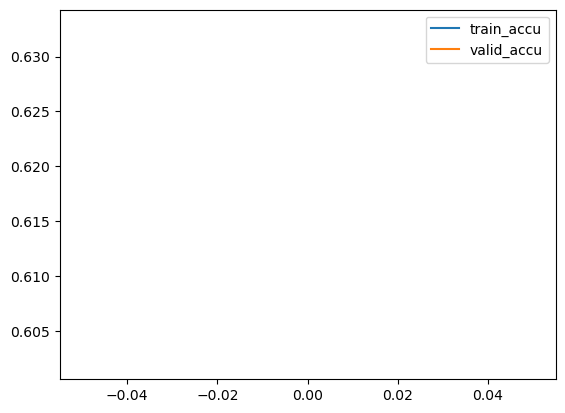

In [18]:
import time
total_accu = None
train_accus=[]
valid_accus=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    model.train()
    total_acc, total_count = 0, 0

    for idx, (xb, label) in enumerate(train_dataloader):
        text, keyword = xb
        optimizer.zero_grad()
        predicted_label = model(text, keyword)
        loss = loss_func(predicted_label, label)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

    accu_train = evaluate(model, train_dataloader)
    accu_valid = evaluate(model, valid_dataloader)
    train_accus.append(accu_train)
    valid_accus.append(accu_valid)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | train f1 {:8.3f} | valid f1 {:8.3f} | lr: {:1.5f}'.format(
        epoch,
        time.time() - epoch_start_time,
        accu_train,
        accu_valid,
        optimizer.param_groups[0]['lr']))

    scheduler.step(accu_valid) # learning rate scheduler after each epoch

import matplotlib.pyplot as plt
plt.plot(train_accus, label='train_accu')
plt.plot(valid_accus, label='valid_accu')
plt.legend()
plt.show()

In [18]:
df_test = pd.read_csv(test_csv)
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [19]:
test_dataset = TwitterDisasterDataset(df_test, word_count=word_count, vocab_size=vocab_size, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

predictions=[]
model.eval()
with torch.no_grad():
    for idx, xb in enumerate(test_dataloader):
        text, keyword = xb
        predicted_label = model(text, keyword)
        predictions.append(predicted_label.argmax(1).cpu().numpy())
        

predictions=np.concatenate(predictions)
print(predictions.shape)

(3263,)


In [20]:
len(predictions)

3263

In [21]:
df_submission = pd.read_csv(submission_csv)
df_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [22]:
df_submission["target"] = predictions
df_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [23]:
df_submission.to_csv("submission.csv", index=False)

In [24]:
df_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.393196
std,3146.427221,0.488535
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000
